In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os


## 简单的道具图像识别, 然后部署到安装上, 这是一个完整的流程,做出来一个简单的应用

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

## 编写一个我自己的custom dataset的模型训练

In [4]:
## 读取道具的 爬虫的数据映射
import json
with open("id_mapping_dict.json") as file:
    json_content = json.loads(file.read())

classes = {v['new_id']:v["zh"]+":"+v["desc"] for i, v in json_content.items() if v.get("new_id")!= None}
# classes

In [5]:
# # ls cus_data/
# from PIL import Image
# dir_path = "cus_data/"
# image = Image.open("cus_data/0.png")
# print(image.size)
# image

# 增加7个随机的背景, 用来合成带背景的图片识别  
这样每个类别的对象就增加到7个这么多了.  

In [6]:
from PIL import Image
from tqdm import tqdm

# 打开背景图像和对象图像
def add_image_bg(bg_image_path, image_path, output_path):
    background = Image.open(bg_image_path)
    background = background.resize((64, 64))
    object_image = Image.open(image_path)
    background.paste(object_image, (0, 0), mask=object_image)

    # 保存叠加后的图像
    background.save(output_path, "PNG")
    return background

def plot_images(images:Image, images_per_row = 9, figsize=(20,20)):  # pil 的图片才能plot
    plt.figure(figsize=figsize)

    # 获取第一张图片的尺寸，假设所有图片尺寸都相同
    image_width, image_height = images[0].size

    # 计算总的行数
    total_rows = len(images) // images_per_row
    total_rows += len(images) % images_per_row

    # 创建一个新的空白图片，尺寸为所有图片拼接后的尺寸
    canvas_width = images_per_row * image_width
    canvas_height = total_rows * image_height
    canvas = Image.new('RGB', (canvas_width, canvas_height))

    # 逐行逐列粘贴图片
    for i, image in enumerate(images):
        row = i // images_per_row
        col = i % images_per_row

        # 计算当前图片在画布上的位置
        left = col * image_width
        top = row * image_height

        # 粘贴图片
        canvas.paste(image, (left, top))

    # 显示拼接后的图片
#     canvas.show()
    plt.imshow(canvas)
    plt.show()

In [7]:
bg_files = [i for i in os.listdir("./cus_background/") if i.find(".")!=0]
bg_files

['bg_00003.png',
 'bg_00002.png',
 'bg_00001.png',
 'bg_00005.png',
 'bg_00011.png',
 'bg_00010.png',
 'bg_00004.png',
 'bg_00012.png',
 'bg_00006.png',
 'bg_00007.png',
 'bg_00009.png',
 'bg_00008.png']

In [8]:
# import os
# output_dir = "new_cus_data"
# os.makedirs(output_dir, exist_ok=True)
# bg_files = [i for i in os.listdir("./cus_background/") if i.find(".")!=0]
# meta_images = [i for i in os.listdir("./cus_data/") if i.find(".")!=0]
# meta_images.sort(key=lambda x: int(x.split(".png")[0]))
# meta_images
# print("总共数量:", len(meta_images))
# print("总共背景数量:", len(bg_files))

# new_meta_images = []
# for image in tqdm(meta_images):
#     for bg in bg_files:
#         bg_path = f"cus_background/{bg}"
#         image_path = f"cus_data/{image}"

#         output_name = image_path.split("/")[-1].strip("png") + bg_path.split("/")[-1]
#         output_path = os.path.join(output_dir, output_name)
#         result = add_image_bg(bg_path, image_path, output_path)
# #       plt.imshow(result)
# #         if len(new_meta_images) >= 30:
# #             continue
# #         else:
# #             new_meta_images.append(result)
            
        
# print("合成完毕")

# # 使用没有边缘模糊的进行训练

In [9]:
# class_len = len(new_meta_images)
# print(class_len)

In [10]:
# plot_images(new_meta_images, figsize=(10, 10))

In [11]:
import torch
import os
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## 构造一个模型

In [12]:
# import torch.nn as nn
# import torch.nn.functional as F


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)  # 计算公式是什么, 需要搞明白
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()
# print(f"device:{device}")
# net.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# # 定义损失函数 和优化器

In [13]:
# 检查transform的效果
from torchvision.transforms import ToTensor
        
transform = transforms.Compose(
    [
        # transforms.ToTensor(),
#         transforms.Resize((64, 64)),  # 将图片尺寸调整为224x224 大的话, 训练时间会更长, 那之前是怎么训练的, 麻了.
        # 增加噪声, 防止过拟合, 因为我还是需要一些现实的照片才可以更准确一些.
#         transforms.ColorJitter(
#             brightness=0.1,
#             contrast=0.1,
#             saturation=0.1,
#             hue=0.1),  # 抖动图像的亮度、对比度、饱和度和色相
        transforms.Lambda(lambda x: x.float()),
#         transforms.Normalize(
#             [43.11019, 42.666084, 42.702415],
#             [100.52347, 99.96471, 100.45631]
#         )  # 对图片数据做正则化
    ])

In [14]:
# ## 检查一下transform的大概效果, 检查的时候也需要打开正则化, 才能显示正常
# import numpy as np
# check_images = []
# for i in range(9):
#     plt.figure(figsize=(1, 1))  # 设置图片尺寸为10x8英寸
#     path = f"new_cus_data/1.bg_{i+1}.png"
#     c_image = read_image(path, 
#                         torchvision.io.image.ImageReadMode.RGB)
#     c_image = transform(c_image)
#     npimg = c_image.numpy()
#     #     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     c_image =  np.transpose(npimg, (1, 2, 0))
#     check_images.append(c_image)
    
# # plot_images(check_images)
#     plt.imshow(c_image)
#     plt.title(c_image.shape)
#     plt.show()

# 此处 开始 00--------00 直接重新用vgg16做的

In [15]:
from torchvision.io import read_image

class IssacCustomDatasets(Dataset):
    def __init__(self, img_sort_files, 
                 img_dir, transform=None, 
                target_transform=None):
        self.img_labels = img_sort_files
        # 自定义标签关系, 此处需要排好序的
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):  # 作用是获得label 和 item 即可
        filename = self.img_labels[idx]        
        img_path = os.path.join(self.img_dir, filename)
        image = read_image(img_path, mode=torchvision.io.image.ImageReadMode.RGB)

        label = int(filename.split(".")[0])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [16]:
# meta_output_dir = "new_mini_20meta_dataset"
# os.makedirs(meta_output_dir, exist_ok=True)

from_dir = "new_cus_data"
need_move_images = os.listdir("new_cus_data/")
need_move_images = [i for i in need_move_images if int(i.split(".")[0]) ] # <= 19]  # 此处设定了 前20类
# need_move_images.sort(key=lambda x: int(x.split(".")[:1]))
need_move_images.sort(key=lambda x: f"{int(x.split('.')[0]):03d}" + f"{x.split('.')[1]}")
print(len(need_move_images))

8616


In [17]:
batch_size = 17 # 15改成了17

# 需要已经排好序
# train_dataset = IssacCustomDatasets(need_move_images, img_dir="new_mini_20meta_dataset/",
#                                     transform=transform)
# labels = list(range(len(os.listdir("cus_data"))))
train_dataset = IssacCustomDatasets(img_sort_files=need_move_images, img_dir="new_cus_data/",
                                    transform=transform)

## dataloader
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True)
# test_loader = train_dataloader

In [21]:
len(need_move_images)

8616

### 完整类别的版本

In [25]:
from torchvision.models import vgg16
import torch.optim as optim
import numpy as np

## 大批量测试的版本

In [28]:
# 获取图片数据的 归一化数值
global_mean = []
global_std = []

for images, labels in train_dataloader:   # dataloader is a DataLoader instance with your dataset
    numpy_image = images.numpy()
    
    # Compute mean and std dev
    batch_mean = np.mean(numpy_image, axis=(0,2,3))
    batch_std = np.std(numpy_image, axis=(0,2,3))
    
    global_mean.append(batch_mean)
    global_std.append(batch_std)

# Final mean and std (use np.mean instead of np.average)
global_mean = np.mean(global_mean, axis=0).tolist()
global_std = np.mean(global_std, axis=0).tolist()
print(global_mean)
print(global_std)

[81.15670013427734, 60.81914138793945, 55.81864547729492]
[55.04219436645508, 46.799015045166016, 47.22174835205078]


In [24]:
# 自定义读取透明背景png的图片
# 根据新的标准差和平均数, 重新运行dataloader
from torchvision.transforms import ToTensor
        
transform = transforms.Compose(
    [
        transforms.RandomAffine(degrees=0, translate=None, scale=(0.9, 1.1), shear=None),  
        # 随机放大或者缩小一点点

        # transforms.ToTensor(),
#         transforms.Resize((64, 64)),  # 将图片尺寸调整为224x224 大的话, 训练时间会更长, 那之前是怎么训练的, 麻了.
        # 增加噪声, 防止过拟合, 因为我还是需要一些现实的照片才可以更准确一些.
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1),  # 抖动图像的亮度、对比度、饱和度和色相
        transforms.Lambda(lambda x: x.float()),
        transforms.Normalize(
            global_mean,
            global_std
        )  # 对图片数据做正则化
    ])


# 需要已经排好序
# train_dataset = IssacCustomDatasets(need_move_images, img_dir="new_mini_20meta_dataset/",
#                                     transform=transform)
# labels = list(range(len(os.listdir("cus_data"))))
train_dataset = IssacCustomDatasets(need_move_images, img_dir="new_cus_data/", transform=transform)

## dataloader
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True)
# test_loader = train_dataloader

In [22]:
total_classes = list(set([i.split(".")[0] for i in need_move_images]))
total_classes_num = len(total_classes)

718

In [18]:
## 大批量测试
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

# net = vgg16(num_classes=total_classes_num)  # 这个倒是完整的
# net.to(device)  # 重建一个模型, 初始化一个  或者我直接用 64 不用于训练模型

class VGG16_S(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_S, self).__init__()
        model = vgg16(pretrained=True)  # 控制变量法, 晚点再看看 True的效果如何 , 试一下 继承特征的
        self.features = model.features  # 只取了feature
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),  # 修改此处的第一个参数
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x
      

In [27]:
## 我的目标是解决这个任务, 而不是 玩 无尽的循环游戏,并且没能获得快乐

In [19]:
new_dict = {v['new_id']:v for i, v in json_content.items() if v.get("new_id")!=None}
new_dict

{0: {'x': 32,
  'y': 0,
  'en': 'The Sad Onion',
  'zh': '悲伤洋葱',
  'level': '1',
  'type': '道具',
  'level2': '3',
  '?': '/',
  'desc': '射速上升。',
  'new_id': 0,
  'image': './cus_data/0.png'},
 1: {'x': 64,
  'y': 0,
  'en': 'The Inner Eye',
  'zh': '内眼',
  'level': '2',
  'type': '道具',
  'level2': '2',
  '?': '/',
  'desc': '角色每次发射3颗泪弹。',
  'new_id': 1,
  'image': './cus_data/1.png'},
 2: {'x': 96,
  'y': 0,
  'en': 'Spoon Bender',
  'zh': '弯勺魔术',
  'level': '3',
  'type': '道具',
  'level2': '3',
  '?': '/',
  'desc': '角色的泪弹获得追踪效果。',
  'new_id': 2,
  'image': './cus_data/2.png'},
 3: {'x': 128,
  'y': 0,
  'en': "Cricket's Head",
  'zh': '柯吉猫的头',
  'level': '4',
  'type': '道具',
  'level2': '4',
  '?': '/',
  'desc': '泪弹变大，击退效果上升，伤害上升。',
  'new_id': 3,
  'image': './cus_data/3.png'},
 4: {'x': 160,
  'y': 0,
  'en': 'My Reflection',
  'zh': '我的镜像',
  'level': '5',
  'type': '道具',
  'level2': '2',
  '?': '/',
  'desc': '角色的泪弹会飞回角色身边。',
  'new_id': 4,
  'image': './cus_data/4.png'},
 5: {'

In [40]:
%%time
# 训练模型

# 如果要继续训练的话, 就用这个
model_path = "20240127_full_64x64_clear_718class_l2__vgg16_24_92.196.pth"  # 这个才是最新的
net = VGG16_S(num_classes=total_classes_num).to(device)  # 这次训练64 * 64的版本
net.load_state_dict(torch.load(model_path))  # 不用百分百的

# 如果不根据之前的进行训练就读取这个
# net = VGG16_S(num_classes=total_classes_num).to(device)  # 这次训练64 * 64的版本


criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)  # 加入了l2正则化
# 换cell 才可以好一点, 不然会出问题

# 60 + 60
check_iter = 10 # train check batch size 
train_epoch = 5
prefix = "20240127_full_64x64_clear_718class_l2_"

for epoch in range(train_epoch):
    net.train()  # 每个epoch 后切换训练模式, 那么会不会保d留之前的训练权重呢?
    
    progress_bar = tqdm(enumerate(train_dataloader, 0), total=len(train_dataloader))
    for i, data in progress_bar:
#     for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data  # 必须要float 归一化? 浮点类型.
        inputs, labels = inputs.float().to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)  # 这一步, 运行有问题, 这是为什么呢, 检查一下图片格式

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
#         print("per batch loss:", loss / batch_size)
#         if i % check_iter == 0:    # 每 4 个小批量打印一次损失值 根本不需要等待, 每次都可以更新, 毕竟是tqdm
#             print('[epoch: %d, iter_num: %5d] loss: %.3f' % (epoch+1, i + 1, loss / batch_size) )
        progress_bar.set_description(f'epoch:{epoch}, loss: {loss / batch_size:.3f}')
    
    if epoch % 3 == 0:  # 每两个epoch进行一次验证
        print("开始验证....")
        net.eval()
        correct = 0  # 记录正确预测的数量
        total = 0  # 总的样本数
        with torch.no_grad():
            
            progress_bar2 = tqdm(enumerate(train_dataloader, 0), total=int(len(train_dataloader) * 0.2))
            for i, data in progress_bar2:
                if i >= int(len(train_dataloader) * 0.2):
                    break
                inputs, labels = data
                inputs, labels = inputs.float().to(device), labels.to(device)
                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)

                # 统计准确率
                total += labels.size(0)  # 实际的样本数
                correct += (predicted == labels).sum().item()  # 正确预测的样本数
#                 print('Real: ', labels, ', Predicted: ', predicted)
        
        accuracy = round(correct / total * 100, 3)  # 计算准确率
        print(f'epoch:{epoch}, Accuracy: {accuracy:.3f}')
#         if accuracy >= 60:
        save_model_path = f"{prefix}_vgg16_{epoch}_{accuracy}.pth"
        torch.save(net.state_dict(), save_model_path)
        print(f"model save: ", save_model_path)
        
    #     print()
    torch.cuda.empty_cache()
print('Finished Training')

save_model_path = f"{prefix}_vgg16_{epoch}_{accuracy}.pth"
torch.save(net.state_dict(), save_model_path)
print(f"model save: ", save_model_path)

epoch:0, loss: 0.041: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [03:06<00:00,  2.72it/s]


开始验证....


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:03<00:00, 29.05it/s]


epoch:0, Accuracy: 92.254
model save:  20240127_full_64x64_clear_718class_l2__vgg16_0_92.254.pth


epoch:3, loss: 0.021: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [03:03<00:00,  2.76it/s]


开始验证....


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:03<00:00, 28.78it/s]


epoch:3, Accuracy: 96.971
model save:  20240127_full_64x64_clear_718class_l2__vgg16_3_96.971.pth


epoch:4, loss: 0.021: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [03:03<00:00,  2.76it/s]


Finished Training
model save:  20240127_full_64x64_clear_718class_l2__vgg16_4_96.971.pth
CPU times: user 5min 4s, sys: 3min 24s, total: 8min 28s
Wall time: 15min 33s


epoch:24, Accuracy: 92.196  
model save:  20240127_full_64x64_clear_718class_l2__vgg16_24_92.196.pth  
Finished Training  
model save:  20240127_full_64x64_clear_718class_l2__vgg16_24_92.196.pth  
CPU times: user 4h 41min 37s, sys: 28min 20s, total: 5h 9min 57s  
Wall time: 1h 19min 47s  

model save:  20240126__vgg16_19_100.0.pth  
CPU times: user 22min 21s, sys: 3min 49s, total: 26min 11s  
Wall time: 49min 32s  

Finished Training  
model save:  20240127_full_64x64_718class_continue__vgg16_4_99.37984496124031.pth  
CPU times: user 43min 38s, sys: 3min 48s, total: 47min 26s  
Wall time: 11min 37s  

In [30]:
## 大概40个epoch就可以了?

In [31]:
1/0

ZeroDivisionError: division by zero

## 用本地的图片进行测试

上面我保存到mps 中执行的保存, 所以后面也需要使用mps才可以? 或者转换成onnx 统一的格式

In [41]:
model_list = [i for i in os.listdir("./") if i.find("20240127_full_64x64_clear_718class_l2__vgg16")!= -1]
model_list.sort(key=lambda x: float(x.split("_")[-1].split(".pth")[0]))
model_list

['20240127_full_64x64_clear_718class_l2__vgg16_3_0.0.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_9_0.0.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_0_0.058.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_6_0.175.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_0_0.757.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_3_8.678.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_6_29.062.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_9_50.029.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_12_51.602.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_0_80.14.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_15_81.479.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_21_83.634.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_18_87.478.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_24_92.196.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_0_92.254.pth',
 '20240127_full_64x64_clear_718class_l2__vgg16_3_96.971.pth',
 '20240127_ful

In [46]:
# model = vgg16(num_classes=20).to(device)
# model_path = "20240127_full_64x64_718class_continue__vgg16_0_96.89922480620154.pth"
# model_path = "20240127_full_64x64_718class__vgg16_19_93.33333333333333.pth"
model_path = "20240127_full_64x64_clear_718class_l2__vgg16_4_96.971.pth"
model_path = "20240127_full_64x64_clear_718class_l2__vgg16_0_92.254.pth"
model_path = "20240127_full_64x64_clear_718class_l2__vgg16_24_92.196.pth"

model = VGG16_S(num_classes=total_classes_num).to(device)  # 这次训练64 * 64的版本
model.load_state_dict(torch.load(model_path))  # 不用百分百的

def get_real_label(class_index):
    print(class_index, 
          new_dict[class_index]['zh'], 
          new_dict[class_index]['en'],
          new_dict[class_index]['desc'])
    return new_dict[class_index]

def eval_predict(model, image_path):
#     test_img = os.path.join("cus_test_data", test_img)
    image = read_image(image_path, mode=torchvision.io.image.ImageReadMode.RGB)
    # image = image.resize(64, 64)
    print()
    
    
    inner_transform = transforms.Compose(
    [
        # transforms.ToTensor(),
        transforms.Resize((64, 64)),  # 将图片尺寸调整为224x224 大的话, 训练时间会更长, 那之前是怎么训练的, 麻了.
        # 增加噪声, 防止过拟合, 因为我还是需要一些现实的照片才可以更准确一些.
        transforms.ColorJitter(
            brightness=0.1,
            contrast=0.1,
            saturation=0.1,
            hue=0.1),  # 抖动图像的亮度、对比度、饱和度和色相
        transforms.Lambda(lambda x: x.float()),
        transforms.Normalize(
            global_mean,
            global_std
        )  # 对图片数据做正则化
    ])
    
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()
    model.eval()
    timg = inner_transform(image)
    timg = timg.to(device)
    timg1 = timg.unsqueeze(0)
    
    # 输入的图片需要改成64 * 64
    
    result = model(timg1)
    result
    _, predicted = torch.max(result, 1)
#     print(predicted.item())
#     print(predicted.item(), 
#           new_dict[predicted.item()]['zh'], 
#           new_dict[predicted.item()]['en'],
#           new_dict[predicted.item()]['desc'])
    get_real_label(predicted.item())
    return result, predicted

/usr/local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


real label:  iShot_2024-01-26_13.55.28.png



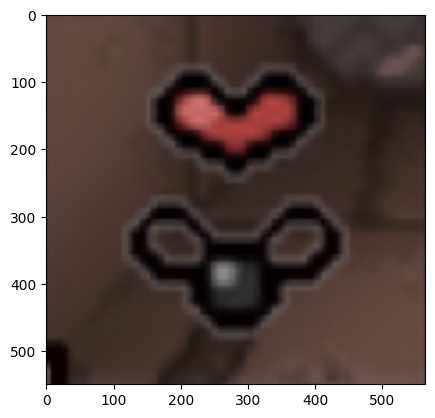

207 蜘蛛宝宝 Spiderbaby 受伤时生成蓝蜘蛛。
最大的5个值: tensor([[0.4489, 0.4086, 0.0754, 0.0246, 0.0103, 0.0088, 0.0038, 0.0038, 0.0028,
         0.0017]], device='mps:0', grad_fn=<TopkBackward0>)
对应的索引: [[207, 8, 376, 73, 680, 332, 616, 360, 647, 537]]
概率: 0.4488961696624756
207 蜘蛛宝宝 Spiderbaby 受伤时生成蓝蜘蛛。


/usr/local/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


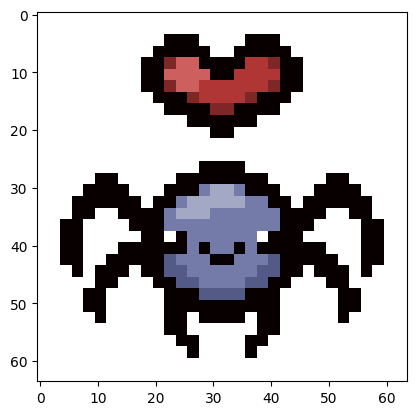


概率: 0.40861207246780396
8 粪臭素 Skatole 苍蝇不再攻击角色。


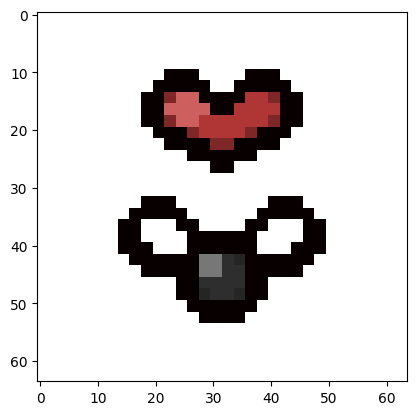


概率: 0.07544013112783432
376 伊甸的祝福 Eden's Blessing 在你的下一局游戏开始时，随机获得一个道具。射速上升。


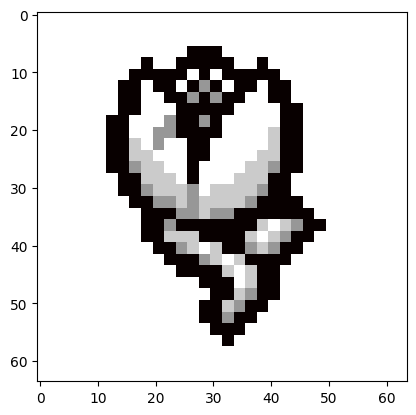


概率: 0.024647431448101997
73 彩虹独角兽 My Little Unicorn 使用后，角色短暂性无敌，能造成接触伤害。


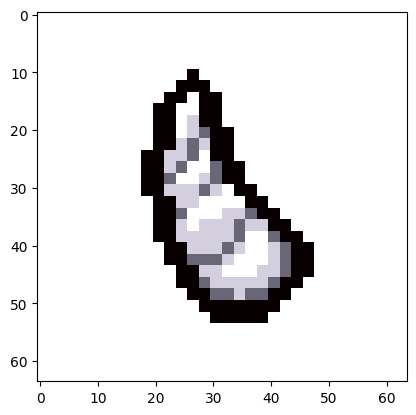


概率: 0.010278861038386822
680 虫群 The Swarm 清理房间会生成1个苍蝇环绕物。苍蝇环绕物阻挡泪弹后会变为蓝苍蝇。


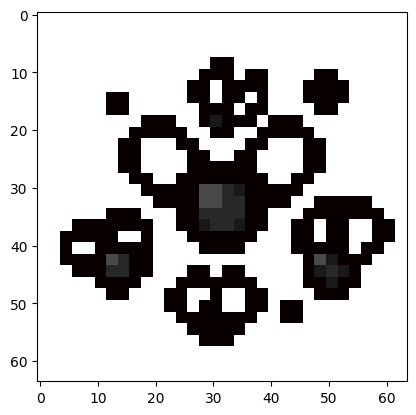


概率: 0.008833526633679867
332 损坏的怀表 Broken Watch 进入房间时，所有敌人概率减速或加速。


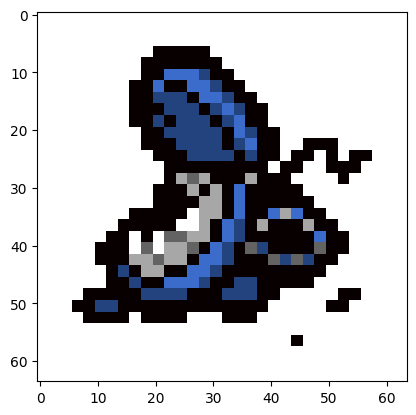


概率: 0.0037857077550143003
616 扩展包 Booster Pack 生成5张卡牌。


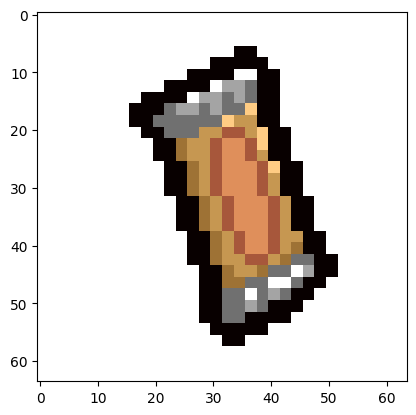


概率: 0.0037590754218399525
360 迷路苍蝇 Lost Fly 沿墙前进的跟班。


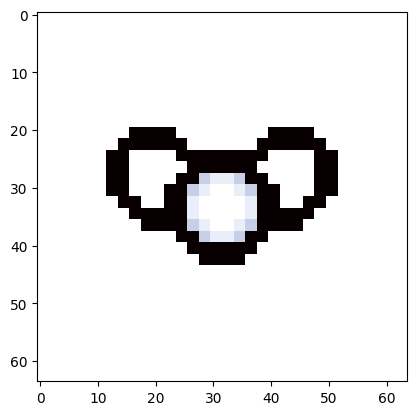


概率: 0.002817208645865321
647 巨细胞 Giant Cell 受伤时生成小以撒跟班。


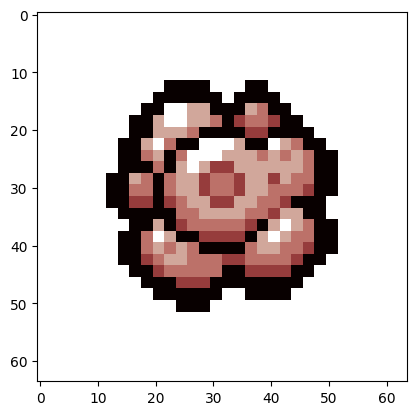


概率: 0.001685045543126762
537 滑肋骨 Slipped Rib 可以反弹敌人泪弹的跟班。


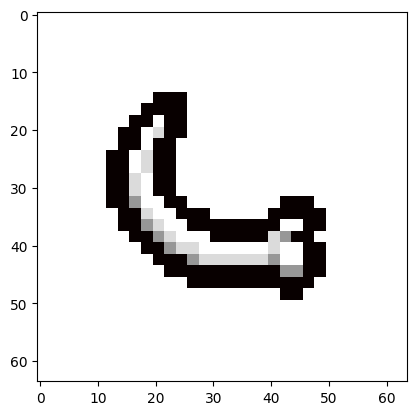

In [62]:
# image_path = "new_cus_data/1.bg_3.png"
# image_path = "/Users/zhengyiming/PycharmProjects/Isaac/new_cus_data/2.bg_8.png"
# image_path = "/Users/zhengyiming/PycharmProjects/Isaac/new_cus_data/15.bg_8.png"

image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-26_13.55.28.png"

# image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-26_12.16.24.png"  # 这种肯定不行啊. 不过没关系, 已经训练好了
# image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-26_12.16.01.png"
# image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-26_12.17.48.png"
# image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-26_12.16.20.png"

# image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-27_13.31.16.png"

# image_path = "/Users/zhengyiming/Downloads/IMG_5039.png"

# image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-27_13.35.42.png"

# image_path = "/Users/zhengyiming/PycharmProjects/Isaac/new_cus_data/267.bg_2.png"

# image_path = "/Users/zhengyiming/Downloads/iShot_2024-01-24_16.17.44.png"
# for i in os.listdir("new_cus_data/"):
#     if i.split(".")[-1] not in ["png", "jpeg", "jpg"]:
#         continue
        
# image_path = os.path.join("new_cus_data", i)

print("real label: ", image_path.split("/")[-1])    
# image_path = os.path.join("cus_test_data", test_img)
result, predicted = eval_predict(model, image_path)


import torch.nn.functional as F

# scores = torch.tensor([1.0, 2.0, 3.0])  
probabilities = F.softmax(result, dim=1)  
# print(probabilities)  

# 使用topk获取最大的5个值及其索引
values, indices = torch.topk(probabilities, 10)
print("最大的5个值:", values)
print("对应的索引:", indices.tolist())

for p, i in zip(values[0].tolist(), indices[0].tolist()):
    print(f"概率:", p)
    data = get_real_label(i)
    plt.imshow(Image.open(data.get("image")))
    plt.show()
    print()
    
# 如何让准确度, 提高得最高呢

In [ ]:
## vgg 16就足够了

In [ ]:
### 接下来的路线

## 1. 增加训练数据量, 增加数据增强
## 2. 测试和验证简单的 自定义模型

## 3. 继续接下来的部署流程, 
### 3.1 部署到移动设备, 安卓或者 ios
### 3.2 直接部署到安卓本身  

## 4. 图像识别改成 目标检测!  


In [ ]:
## 导出, 并且转移到安卓上. d